In [2]:
import pandas as pd
import json
import  tarfile
import bz2
import os
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk import agreement
import statsmodels.formula.api as smf
sns.set_style('whitegrid')
%matplotlib inline
import random
import matplotlib.patches as mpatches
import math

import multiprocessing
import json
import os
import re
import datetime
import time
import pprint
from datetime import datetime
from datetime import timedelta
import pytz
import glob
from random import sample
import pickle
from datetime import date, timedelta
from scipy import stats

In [3]:
languages = ['ar',
 'zh',
 'nl',
 'en',
 'et',
 'fr',
 'de',
 'ht',
 'hi',
 'in',
 'it',
 'ja',
 'ko',
 'fa',
 'pl',
 'pt',
 'ru',
 'es',
 'sv',
 'tl',
 'th',
 'tr',
 'ur']

mapping_lang_codes = {}
mapping_lang_codes['ja'] = 'Japanese'
mapping_lang_codes['en'] = 'English'
mapping_lang_codes['pt'] = 'Portuguese'
mapping_lang_codes['es'] = 'Spanish'
mapping_lang_codes['ar'] = 'Arabic'
mapping_lang_codes['ko'] = 'Korean'
mapping_lang_codes['in'] = 'Indonesian'
mapping_lang_codes['tl'] = 'Tagalog'
mapping_lang_codes['tr'] = 'Turkish'
mapping_lang_codes['fr'] = 'French'
mapping_lang_codes['th'] = 'Thai'
mapping_lang_codes['ru'] = 'Russian'
mapping_lang_codes['it'] = 'Italian'
mapping_lang_codes['de'] = 'German'
mapping_lang_codes['pl'] = 'Polish'
mapping_lang_codes['hi'] = 'Hindi'
mapping_lang_codes['fa'] = 'Persian'
mapping_lang_codes['nl'] = 'Dutch'
mapping_lang_codes['ht'] = 'Haitian Creole'
mapping_lang_codes['et'] = 'Estonian'
mapping_lang_codes['zh'] = 'Chinese'
mapping_lang_codes['ur'] = 'Urdu'
mapping_lang_codes['sv'] = 'Swedish'

In [4]:
files = []
for i in range(40):
    files.append("derived_dataset/lengths_derived_dataset_batch_"+str(i+1)+".parquet")

In [121]:
allowed_sources = ['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
    '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
    '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
    '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M2)</a>',
    '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
    '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
    '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Lite</a>',
    '<a href="http://www.twitter.com" rel="nofollow">Twitter for Windows</a>',
    '<a href="http://www.twitter.com" rel="nofollow">Twitter for Windows Phone</a>',
    '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>']

### Sources statistics

In [6]:
def process_batch(file):
    df = pd.read_parquet(file)
    df = df.loc[df['lang'].isin(languages)]

    df_stats = df.groupby('lang').apply(lambda x: pd.Series({
            'histogram_sources': x['source'].value_counts()
            }))
    
    return df_stats


In [8]:
p = multiprocessing.Pool(5)
print('Parallelized on number of cores:',multiprocessing.cpu_count())

start = time.time()

output_regular = p.map(process_batch, files)

p.close()
p.join()

end = time.time()
elapsed = end - start

print('Elapsed time:',time.strftime("%H:%M:%S", time.gmtime(elapsed)))

Parallelized on number of cores: 48
Elapsed time: 00:10:25


In [10]:
hist_before_regular = []


for c,lang in enumerate(languages):
    for cnt,item in enumerate(output_regular):
        if cnt==0:
            hist_2017 = item.loc[lang]['histogram_sources']
        else:
            hist_2017 = hist_2017.add(item.loc[lang]['histogram_sources'],fill_value=0)

    
    #h= np.array([hist_2017[i] if i in hist_2017.index else 0 for i in range(1,281)])/sum(hist_2017)
 

    hist_before_regular.append(hist_2017)


In [26]:
hist_before_regular[0].sort_values(ascending = False)[:10]/sum(hist_before_regular[0])

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>      0.564104
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>    0.282537
<a href="http://twitquran.com/About.aspx" rel="nofollow"> تويت قرآن</a>                 0.032817
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                      0.032777
<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>                 0.011154
<a href="https://mobile.twitter.com" rel="nofollow">Twitter Lite</a>                    0.009917
<a href="http://k-632.com" rel="nofollow">تطبيق مغرد بِذكر الله</a>                     0.008923
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>       0.007412
<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>                   0.007111
<a href="https://ifttt.com" rel="nofollow">IFTTT</a>                                    0.006539
Name: source, dtype: float64

In [122]:
list_items = []

for c,lang in enumerate(languages):
    item = {}
    
    
    item['language'] = (mapping_lang_codes[lang])
    
    item['percent_regular_sources'] = str(round(100*((hist_before_regular[c][allowed_sources]/sum(hist_before_regular[c])).sum()),2))+'%'
    
    cnt = 0
    for j in ([(i.split('>')[1].split('<')[0]) for i in (hist_before_regular[c][allowed_sources].sort_values(ascending = False)/sum(hist_before_regular[c])).index[:5]]):
        item['top_regular_type'+str(cnt+1)] = j + " ("+str(round(100*(hist_before_regular[c][allowed_sources].sort_values(ascending = False)/sum(hist_before_regular[c])).values[:5][cnt],2)) + "%)"
        cnt+=1
        
    cnt=0
    for j in ((hist_before_regular[c][allowed_sources]/sum(hist_before_regular[c])).values[:5]):
        #item['top_regular_percent'+str(cnt+1)] = str(round(100*j,2))+'%'
        cnt+=1
    
    
    item['percent_other_sources'] = str(round(100*(1-(hist_before_regular[c][allowed_sources]/sum(hist_before_regular[c])).sum()),2))+'%'
    
    cnt = 0
    for j in ([( i.split('>')[1].split('<')[0]) for i in (hist_before_regular[c].sort_values(ascending = False).loc[~hist_before_regular[c]\
                                                    .sort_values(ascending = False)\
                                                    .index.isin(allowed_sources)][:5]/sum(hist_before_regular[c])).index]):
        item['top_other_type'+str(cnt+1)] = j + " ("+ str(round(100*((hist_before_regular[c].sort_values(ascending = False).loc[~hist_before_regular[c]\
                                                    .sort_values(ascending = False)\
                                                    .index.isin(allowed_sources)][:5]/sum(hist_before_regular[c])).values)[cnt],2))+'%)'
        cnt+=1
        
    print((hist_before_regular[c].sort_values(ascending = False).loc[~hist_before_regular[c]\
                                                    .sort_values(ascending = False)\
                                                    .index.isin(allowed_sources)][:5]/sum(hist_before_regular[c])))
        
    cnt = 0
    for j in ((hist_before_regular[c].sort_values(ascending = False).loc[~hist_before_regular[c]\
                                                    .sort_values(ascending = False)\
                                                    .index.isin(allowed_sources)][:5]/sum(hist_before_regular[c])).values):
        #item['top_other_percent'+str(cnt+1)] = j
        cnt+=1

    

    
    list_items.append(item)


<a href="http://twitquran.com/About.aspx" rel="nofollow"> تويت قرآن</a>     0.032817
<a href="http://k-632.com" rel="nofollow">تطبيق مغرد بِذكر الله</a>         0.008923
<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>       0.007111
<a href="https://ifttt.com" rel="nofollow">IFTTT</a>                        0.006539
<a href="http://twasul-news.com/tw2" rel="nofollow">twasul news apps</a>    0.006434
Name: source, dtype: float64
<a href="http://twittbot.net/" rel="nofollow">twittbot.net</a>                                                     0.077204
<a href="http://chrome.google.com/extensions/detail/aicelmgbddfgmpieedjiggifabdpcnln" rel="nofollow">FaWave</a>    0.029164
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>                                0.028943
<a href="http://tapbots.com/tweetbot" rel="nofollow">Tweetbot for iΟS</a>                                          0.008279
<a href="http://www.facebook.com/twitter" rel="nof

<a href="https://ifttt.com" rel="nofollow">IFTTT</a>                                   0.008284
<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>                  0.005215
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    0.004423
<a href="http://twittbot.net/" rel="nofollow">twittbot.net</a>                         0.003058
<a href="http://www.tweetcaster.com" rel="nofollow">TweetCaster for Android</a>        0.000714
Name: source, dtype: float64
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    0.011262
<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>                  0.005552
<a href="http://twittbot.net/" rel="nofollow">twittbot.net</a>                         0.004657
<a href="http://tapbots.com/tweetbot" rel="nofollow">Tweetbot for iΟS</a>              0.001282
<a href="http://www.tweetcaster.com" rel="nofollow">TweetCaster for Android</a>        0.000978
Name: sourc

In [123]:
pd.DataFrame(list_items)

,language,percent_regular_sources,top_regular_type1,top_regular_type2,top_regular_type3,top_regular_type4,top_regular_type5,percent_other_sources,top_other_type1,top_other_type2,top_other_type3,top_other_type4,top_other_type5
0,Arabic,91.06%,Twitter for iPhone (56.41%),Twitter for Android (28.25%),Twitter Web Client (3.28%),Twitter Web App (1.12%),Twitter Lite (0.99%),8.94%,تويت قرآن (3.28%),تطبيق مغرد بِذكر الله (0.89%),Facebook (0.71%),IFTTT (0.65%),twasul news apps (0.64%)
1,Chinese,80.89%,Twitter for iPhone (23.96%),Twitter for Android (23.46%),Twitter Web Client (22.58%),Twitter Lite (5.07%),Twitter Web App (3.58%),19.11%,twittbot.net (7.72%),FaWave (2.92%),TweetDeck (2.89%),Tweetbot for iΟS (0.83%),Facebook (0.72%)
2,Dutch,86.22%,Twitter for Android (32.55%),Twitter for iPhone (31.71%),Twitter Web Client (13.51%),Twitter for iPad (3.53%),Twitter Web App (2.86%),13.78%,TweetDeck (2.65%),IFTTT (2.4%),twittbot.net (0.75%),Tweetbot for iΟS (0.55%),Facebook (0.51%)
3,English,91.23%,Twitter for iPhone (48.03%),Twitter for Android (25.45%),Twitter Web Client (10.95%),Twitter Web App (2.59%),Twitter for iPad (1.96%),8.77%,TweetDeck (1.7%),twittbot.net (1.04%),IFTTT (0.93%),Facebook (0.41%),Tweetbot for iΟS (0.24%)
4,Estonian,84.85%,Twitter for Android (45.49%),Twitter for iPhone (26.12%),Twitter Web Client (7.09%),Twitter Web App (2.52%),Twitter Lite (1.98%),15.15%,IFTTT (5.22%),TweetDeck (1.86%),twittbot.net (1.72%),IFTTT (0.91%),Facebook (0.52%)
5,French,95.24%,Twitter for iPhone (47.39%),Twitter for Android (31.87%),Twitter Web Client (10.92%),Twitter Web App (2.06%),Twitter for iPad (1.26%),4.76%,TweetDeck (1.51%),IFTTT (0.49%),Facebook (0.24%),twittbot.net (0.15%),Google (0.14%)
6,German,86.96%,Twitter for Android (38.41%),Twitter for iPhone (24.07%),Twitter Web Client (16.79%),Twitter Web App (3.39%),Twitter for iPad (2.03%),13.04%,TweetDeck (3.18%),IFTTT (1.82%),Tweetbot for iΟS (0.89%),twittbot.net (0.79%),Facebook (0.32%)
7,Haitian Creole,83.12%,Twitter for iPhone (37.6%),Twitter for Android (34.79%),Twitter Web Client (6.04%),Twitter Web App (1.94%),Twitter Lite (1.43%),16.88%,IFTTT (6.86%),TweetDeck (2.54%),twittbot.net (1.32%),IFTTT (0.59%),Facebook (0.35%)
8,Hindi,94.55%,Twitter for Android (72.07%),Twitter for iPhone (9.74%),Twitter Web Client (5.65%),Twitter Web App (3.31%),Twitter Lite (2.32%),5.45%,Facebook (1.55%),Cloudhopper (0.9%),TweetCaster for Android (0.9%),TweetDeck (0.4%),IFTTT (0.31%)
9,Indonesian,83.61%,Twitter for Android (56.17%),Twitter for iPhone (18.7%),Twitter Web Client (3.71%),Twitter Web App (2.28%),Twitter Lite (1.6%),16.39%,twittbot.net (5.54%),IFTTT (4.82%),IFTTT (1.07%),TweetDeck (1.02%),Facebook (0.56%)


# -----------------------------------------

## a) Normal users

In [5]:



def process_batch(file):
    df = pd.read_parquet(file)
    df = df.loc[df['lang'].isin(languages)]
    df = df.loc[df['source'].isin(allowed_sources)]
    df_stats = df.groupby('lang').apply(lambda x: pd.Series({
            'histogram_characters_2017': x.loc[(x['created_at'].dt.year == 2017) & (x['created_at'].dt.month < 11)]['n_chars'].value_counts(),
            'histogram_characters_2019': x.loc[(x['created_at'].dt.year == 2019) & (x['created_at'].dt.month < 11)]['n_chars'].value_counts()
            }))
    
    return df_stats

In [6]:
p = multiprocessing.Pool(10)
print('Parallelized on number of cores:',multiprocessing.cpu_count())

start = time.time()

output_regular = p.map(process_batch, files)

p.close()
p.join()

end = time.time()
elapsed = end - start

print('Elapsed time:',time.strftime("%H:%M:%S", time.gmtime(elapsed)))

Parallelized on number of cores: 48
Elapsed time: 00:13:42


### sort languages by 140 peak

In [7]:
peaks_140 = []
peaks_280 = []

hist_before_regular = []
hist_after_regular = []

for c,lang in enumerate(languages):
    for cnt,item in enumerate(output_regular):
        if cnt==0:
            hist_2017 = item.loc[lang]['histogram_characters_2017']
            hist_2019 = item.loc[lang]['histogram_characters_2019']
        else:
            hist_2017 = hist_2017.add(item.loc[lang]['histogram_characters_2017'],fill_value=0)
            hist_2019 = hist_2019.add(item.loc[lang]['histogram_characters_2019'],fill_value=0)
    
    h1 = np.array([hist_2017[i] if i in hist_2017.index else 0 for i in range(1,281)])/sum(hist_2017)
    h2 = np.array([hist_2019[i] if i in hist_2019.index else 0 for i in range(1,281)])/sum(hist_2019)
    

    hist_before_regular.append(h1)
    hist_after_regular.append(h2)
    
    peaks_140.append(h1[139])
    peaks_280.append(h2[279])

In [8]:
for i in range(len(peaks_140)):
    print(languages[i])
    print(peaks_280[i])

ar
0.002704073635118551
zh
0.0
nl
0.005181353501428029
en
0.005042240067334243
et
0.003099732053715535
fr
0.004022398075485047
de
0.007752984617473649
ht
0.0008095184875294885
hi
0.011035034839821748
in
0.0017353664171936157
it
0.0058509847222801776
ja
0.0
ko
9.268095701985495e-08
fa
0.006601965403097884
pl
0.00433392420201676
pt
0.001887355184542423
ru
0.005720529868641738
es
0.004970428979850941
sv
0.005784524158804182
tl
0.0007521201292624457
th
0.0016339456681780814
tr
0.006121700758986058
ur
0.008302079853873247


In [10]:
peaks_sorted, lang_sorted \
    = zip(*sorted(zip(peaks_140, languages)))

In [11]:
peaks_sorted, peaks_280_sorted \
    = zip(*sorted(zip(peaks_140, peaks_280)))

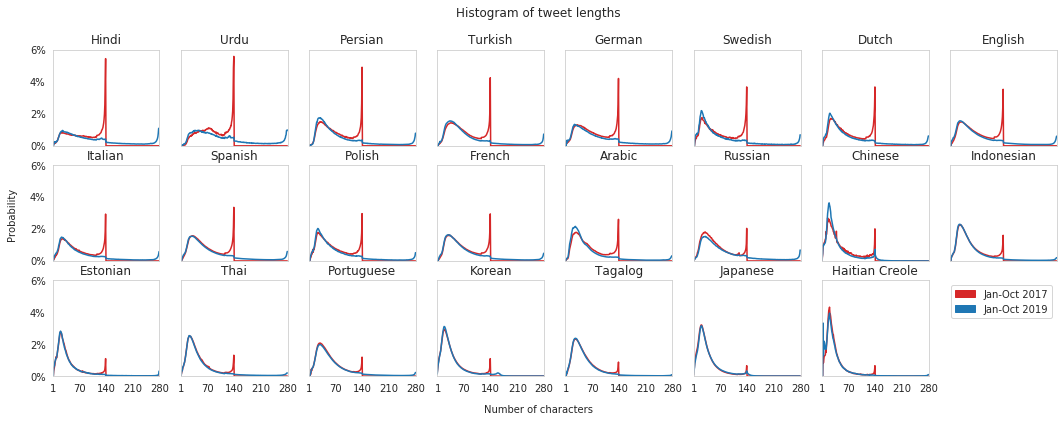

In [12]:
fig, ax = plt.subplots(3,8,figsize= (18,6), sharey = False, sharex =  False)

for c,lang in enumerate(lang_sorted[::-1]):
    sbplt = ax[math.floor(c/8),c%8]

    
    for cnt,item in enumerate(output_regular):
        if cnt==0:
            hist_2017 = item.loc[lang]['histogram_characters_2017']
            hist_2019 = item.loc[lang]['histogram_characters_2019']
        else:
            hist_2017 = hist_2017.add(item.loc[lang]['histogram_characters_2017'],fill_value=0)
            hist_2019 = hist_2019.add(item.loc[lang]['histogram_characters_2019'],fill_value=0)
 
    sbplt.plot(np.array([hist_2017[i] if i in hist_2017.index else 0 for i in range(1,281)])/sum(hist_2017), color = 'tab:red')
    sbplt.plot(np.array([hist_2019[i] if i in hist_2019.index else 0 for i in range(1,281)])/sum(hist_2019), color = 'tab:blue')
    
    sbplt.set_xlim([0,280])
    sbplt.set_ylim([0,0.05])
    sbplt.set_title(mapping_lang_codes[lang])
    sbplt.grid(False) 
    
    if c%8 == 0:
        sbplt.set_yticks([0,0.02,0.04,0.06])
        sbplt.set_yticklabels(['0%','2%','4%','6%'])
    else:
        sbplt.set_yticks([])
    
    if math.floor(c/8) == 2:
        sbplt.set_xticks(np.concatenate(([1],range(0,281)[::70][1:])))
    else:
        sbplt.set_xticks([])
    
sbplt = ax[2,7]

red_patch = mpatches.Patch(color='tab:red', label='Jan-Oct 2017')
blue_patch = mpatches.Patch(color='tab:blue', label='Jan-Oct 2019')
sbplt.legend(handles=[red_patch,blue_patch])

sbplt.grid(False) 
sbplt.set_xticks([])
sbplt.set_yticks([])
sbplt.spines['right'].set_visible(False)
sbplt.spines['top'].set_visible(False)
sbplt.spines['bottom'].set_visible(False)
sbplt.spines['left'].set_visible(False)

plt.suptitle('Histogram of tweet lengths')
fig.text(0.5, 0.04, 'Number of characters', ha='center')
fig.text(0.09, 0.5, 'Probability', va='center', rotation='vertical')

plt.savefig("fig4.pdf", bbox_inches='tight')

1. laguages sorted by prevalence of 140 before the switch
2. prevalence of 140 before the switch is correlated with prevalence of 280 after
3. the first peak remains constant, the "mass of the histogram" is constant, interesting points are 140 and 280

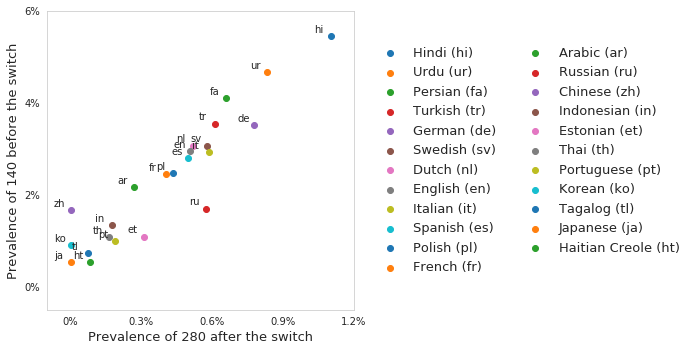

In [19]:
fig, ax = plt.subplots(1,1,figsize= (5.5,5.5))

for i in range(23)[::-1]:
    plt.scatter(peaks_280_sorted[i],peaks_sorted[i],
                label = mapping_lang_codes[lang_sorted[i]] + " (" + lang_sorted[i] + ")")
    ax.annotate(lang_sorted[i], (peaks_280_sorted[i]-0.0007, peaks_sorted[i]+0.0008))
    
plt.ylim([-0.005,0.06])
plt.ylabel('Prevalence of 140 before the switch', fontsize = 13)
plt.xlabel('Prevalence of 280 after the switch', fontsize = 13)

plt.xlim([-0.001,0.012])
plt.xticks([0,0.003,0.006,0.009,0.012],["0%","0.3%","0.6%","0.9%","1.2%"])
plt.yticks([0,0.02,0.04,0.06],["0%","2%","4%","6%"])
plt.grid(False) 
plt.legend(ncol = 2, loc = 'right', bbox_to_anchor = (2.1,0.5),frameon=False,fontsize = 13)

plt.savefig("fig5.pdf", bbox_inches='tight')

In [ ]:
stats.spearmanr(peaks_140,peaks_280)

1. this resonates with the narrative that 280 is the new 140 because the more 140 was used in a language before the switch, the more 280 is used after
2. "280 is the new 140" crosslingual adoption of Twitter's length affordance innovation

## b) Automated users

In [47]:
allowed_languages = ['ar',
 'nl',
 'en',
 'et',
 'fr',
 'de',
 'ht',
 'hi',
 'in',
 'it',
 'fa',
 'pl',
 'pt',
 'ru',
 'es',
 'sv',
 'tl',
 'th',
 'tr',
 'ur']

In [48]:
def process_batch_bots(file):
    df = pd.read_parquet(file)
    df = df.loc[df['lang'].isin(languages)]
    df = df.loc[~df['source'].isin(allowed_sources)]
    df_stats = df.groupby('lang').apply(lambda x: pd.Series({
            'histogram_characters_2017': x.loc[(x['created_at'].dt.year == 2017) & (x['created_at'].dt.month < 11)]['n_chars'].value_counts(),
            'histogram_characters_2019': x.loc[(x['created_at'].dt.year == 2019) & (x['created_at'].dt.month < 11)]['n_chars'].value_counts()
            }))
    
    return df_stats

In [49]:
p = multiprocessing.Pool(10)
print('Parallelized on number of cores:',multiprocessing.cpu_count())

start = time.time()

output = p.map(process_batch_bots, files)

p.close()
p.join()

end = time.time()
elapsed = end - start

print('Elapsed time:',time.strftime("%H:%M:%S", time.gmtime(elapsed)))

Parallelized on number of cores: 48
Elapsed time: 00:04:49


In [50]:
peaks_140_bots = []
peaks_280_bots = []

hist_before_bots = []
hist_after_bots = []

for c,lang in enumerate(languages):
    for cnt,item in enumerate(output):
        if cnt==0:
            hist_2017 = item.loc[lang]['histogram_characters_2017']
            hist_2019 = item.loc[lang]['histogram_characters_2019']
        else:
            hist_2017 = hist_2017.add(item.loc[lang]['histogram_characters_2017'],fill_value=0)
            hist_2019 = hist_2019.add(item.loc[lang]['histogram_characters_2019'],fill_value=0)
    
    h1 = np.array([hist_2017[i] if i in hist_2017.index else 0 for i in range(1,281)])/sum(hist_2017)
    h2 = np.array([hist_2019[i] if i in hist_2019.index else 0 for i in range(1,281)])/sum(hist_2019)
    

    hist_before_bots.append(h1)
    hist_after_bots.append(h2)
        
    peaks_140_bots.append(h1[139])
    peaks_280_bots.append(h2[279])

In [51]:
peaks_sorted_bots, peaks_280_sorted_bots, lang_sorted \
    = zip(*sorted(zip(peaks_140_bots, peaks_280_bots, languages)))

Text(0.1, 0.5, 'number of characters')

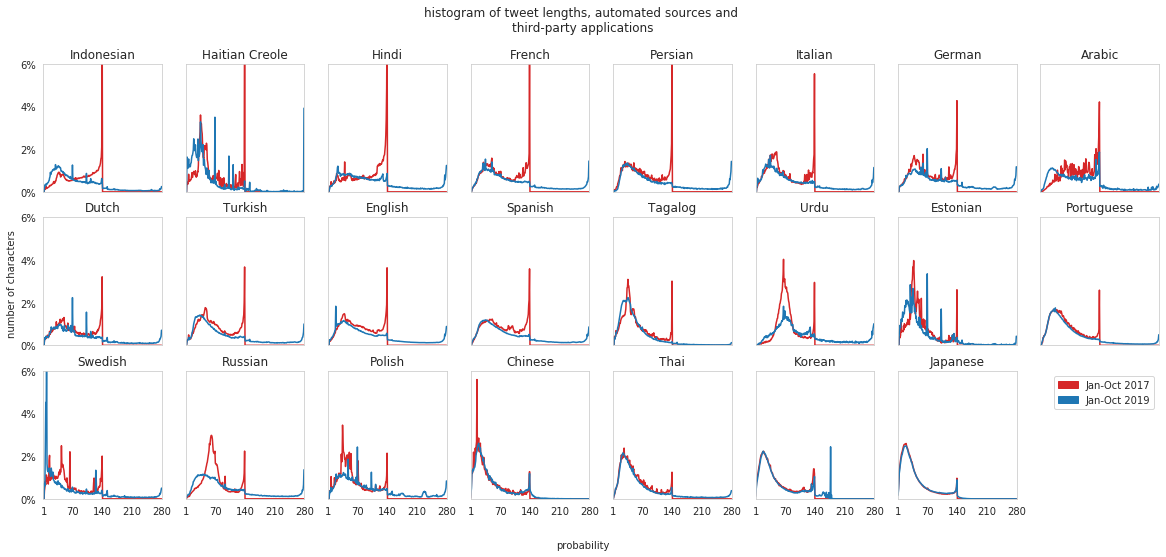

In [52]:
fig, ax = plt.subplots(3,8,figsize= (20,8), sharey = False, sharex =  False)

for c,lang in enumerate(lang_sorted[::-1]):
    sbplt = ax[math.floor(c/8),c%8]

    
    for cnt,item in enumerate(output):
        if cnt==0:
            hist_2017 = item.loc[lang]['histogram_characters_2017']
            hist_2019 = item.loc[lang]['histogram_characters_2019']
        else:
            hist_2017 = hist_2017.add(item.loc[lang]['histogram_characters_2017'],fill_value=0)
            hist_2019 = hist_2019.add(item.loc[lang]['histogram_characters_2019'],fill_value=0)
 
    sbplt.plot(np.array([hist_2017[i] if i in hist_2017.index else 0 for i in range(1,281)])/sum(hist_2017), color = 'tab:red')
    sbplt.plot(np.array([hist_2019[i] if i in hist_2019.index else 0 for i in range(1,281)])/sum(hist_2019), color = 'tab:blue')
    
    sbplt.set_xlim([0,280])
    sbplt.set_ylim([0,0.05])
    sbplt.set_title(mapping_lang_codes[lang])
    sbplt.grid(False) 
    
    if c%8 == 0:
        sbplt.set_yticks([0,0.02,0.04,0.06])
        sbplt.set_yticklabels(['0%','2%','4%','6%'])
    else:
        sbplt.set_yticks([])
    
    if math.floor(c/8) == 2:
        sbplt.set_xticks(np.concatenate(([1],range(0,281)[::70][1:])))
    else:
        sbplt.set_xticks([])
    
sbplt = ax[2,7]

red_patch = mpatches.Patch(color='tab:red', label='Jan-Oct 2017')
blue_patch = mpatches.Patch(color='tab:blue', label='Jan-Oct 2019')
sbplt.legend(handles=[red_patch,blue_patch])

sbplt.grid(False) 
sbplt.set_xticks([])
sbplt.set_yticks([])
sbplt.spines['right'].set_visible(False)
sbplt.spines['top'].set_visible(False)
sbplt.spines['bottom'].set_visible(False)
sbplt.spines['left'].set_visible(False)

plt.suptitle('histogram of tweet lengths, automated sources and \nthird-party applications')
fig.text(0.5, 0.04, 'probability', ha='center')
fig.text(0.1, 0.5, 'number of characters', va='center', rotation='vertical')

### bots use 140 in most of the languages

Text(0.5, 1.0, 'Jan-Oct 2019')

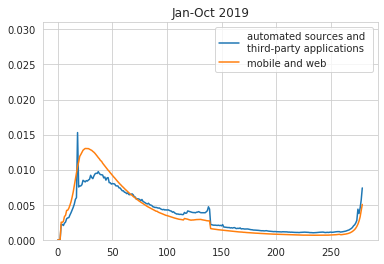

In [53]:
plt.plot(hist_after_bots[3], label = 'automated sources and \nthird-party applications')
plt.plot(hist_after_regular[3], label = 'mobile and web')
plt.ylim([0,0.031])
plt.legend()
plt.title('Jan-Oct 2019')

Text(0.5, 1.0, 'Jan-Oct 2017')

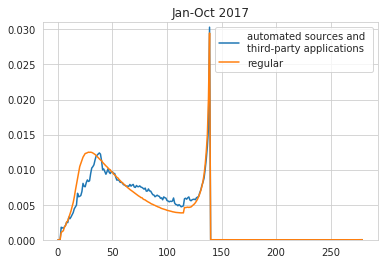

In [54]:
plt.plot(hist_before_bots[3], label = 'automated sources and \nthird-party applications')
plt.plot(hist_before_regular[3], label = 'regular')
plt.ylim([0,0.031])
plt.legend()
plt.title('Jan-Oct 2017')

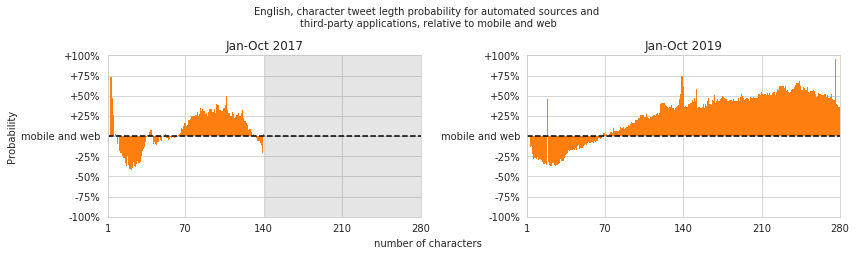

In [57]:
fig, ax = plt.subplots(1,2,figsize= (12,3))

sbplt = ax[0]

sbplt.bar(np.array(range(1,281)),[(hist_before_bots[3][i] - hist_before_regular[3][i])/hist_before_regular[3][i] \
    if hist_after_regular[3][i]>0  and i<140 else 0
    for i in range(len(hist_after_regular[3]))], width = 1,
        align = 'center',color = 'tab:orange',linewidth = 0, edgecolor = 'black')

sbplt.set_ylim([-1,1])
sbplt.set_xlim([1,280])
sbplt.hlines(0,1,280, linestyle = '--')
sbplt.set_yticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
sbplt.set_yticklabels(["-100%","-75%","-50%","-25%","mobile and web","+25%","+50%","+75%","+100%"])

sbplt.set_ylabel('Probability')
sbplt.set_title('Jan-Oct 2017')
sbplt.set_xticks(np.concatenate(([1],range(0,281)[::70][1:])))
sbplt.axvspan(141,280, ymin=-1, ymax=1, alpha=0.2, color='gray')
sbplt = ax[1]

sbplt.bar(np.array(range(1,281)),[(hist_after_bots[3][i] - hist_after_regular[3][i])/hist_after_regular[3][i] \
    if hist_after_regular[3][i]>0 else 0
    for i in range(len(hist_after_regular[3]))], width = 1,
        align = 'center',color = 'tab:orange',linewidth = 0, edgecolor = 'black')

sbplt.set_ylim([-1,1])
sbplt.set_xlim([1,280])
sbplt.hlines(0,1,280, linestyle = '--')
sbplt.set_yticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
sbplt.set_yticklabels(["-100%","-75%","-50%","-25%","mobile and web","+25%","+50%","+75%","+100%"])

fig.text(0.5, -0.01, 'number of characters', ha='center')
sbplt.set_title('Jan-Oct 2019')
sbplt.set_xticks(np.concatenate(([1],range(0,281)[::70][1:])))
fig.tight_layout()
fig.text(0.5, 1.01, 'English, character tweet legth probability for automated sources and \nthird-party applications, relative to mobile and web', ha='center')




1. bots shift proportional to loger ranges, and get stuck at 140

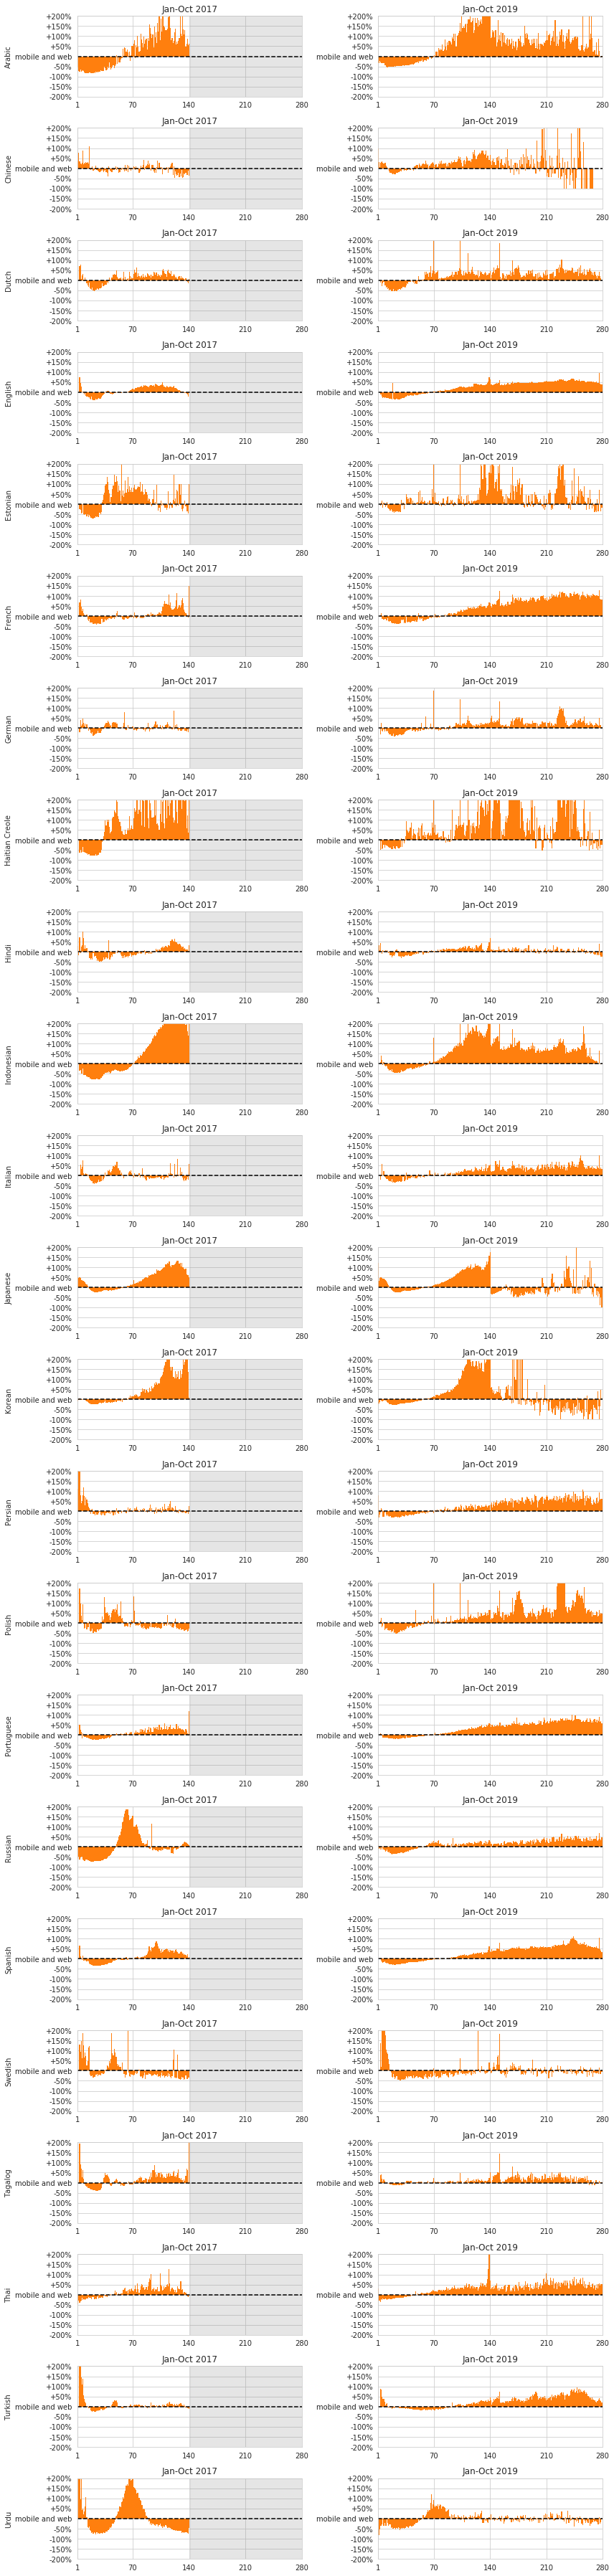

In [408]:
fig, ax = plt.subplots(23,2,figsize= (12,50))


for cnt_lang,lang in enumerate(languages):
    sbplt = ax[cnt_lang,0]

    sbplt.bar(np.array(range(1,281)),[(hist_before_bots[cnt_lang][i] - hist_before_regular[cnt_lang][i])/hist_before_regular[cnt_lang][i] \
        if hist_after_regular[cnt_lang][i]>0  and i<140 else 0
        for i in range(len(hist_after_regular[cnt_lang]))], width = 1,
            align = 'center',color = 'tab:orange',linewidth = 0, edgecolor = 'black')

    sbplt.set_ylim([-2,2])
    sbplt.set_xlim([1,280])
    sbplt.hlines(0,1,280, linestyle = '--')
    sbplt.set_yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
    sbplt.set_yticklabels(["-200%","-150%","-100%","-50%","mobile and web","+50%","+100%","+150%","+200%"])

    sbplt.set_ylabel(mapping_lang_codes[lang])
    sbplt.set_title('Jan-Oct 2017')
    sbplt.set_xticks(np.concatenate(([1],range(0,281)[::70][1:])))
    sbplt.axvspan(141,280, ymin=-1, ymax=1, alpha=0.2, color='gray')

    sbplt = ax[cnt_lang,1]

    sbplt.bar(np.array(range(1,281)),[(hist_after_bots[cnt_lang][i] - hist_after_regular[cnt_lang][i])/hist_after_regular[cnt_lang][i] \
        if hist_after_regular[cnt_lang][i]>0 else 0
        for i in range(len(hist_after_regular[cnt_lang]))], width = 1,
            align = 'center',color = 'tab:orange',linewidth = 0, edgecolor = 'black')

    sbplt.set_ylim([-2,2])
    sbplt.set_xlim([1,280])
    sbplt.hlines(0,1,280, linestyle = '--')
    sbplt.set_yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
    sbplt.set_yticklabels(["-200%","-150%","-100%","-50%","mobile and web","+50%","+100%","+150%","+200%"])

    #fig.text(0.5, -0.01, 'number of characters', ha='center')
    sbplt.set_title('Jan-Oct 2019')
    sbplt.set_xticks(np.concatenate(([1],range(0,281)[::70][1:])))
    fig.tight_layout()
    #fig.text(0.5, 1.01, 'English, character tweet legth probability for automated sources and \nthird-party applications, relative to mobile and web', ha='center')


### Show for five biggest non Japanese/Korean/Chinese languages: English, portuguese, Spanish, Arabic, Indonesian

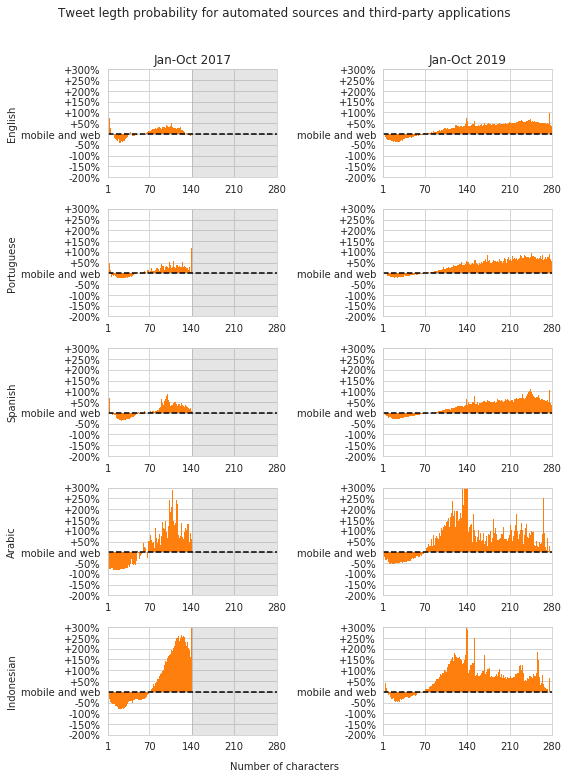

In [86]:
fig, ax = plt.subplots(5,2,figsize= (8,10))

chosen_lang = ['en','pt','es','ar','in']
c = 0
for cnt_lang,lang in enumerate(languages):
    if lang in chosen_lang:
        c = chosen_lang.index(lang)+1
        pass
    else:
        continue
        
    sbplt = ax[c-1,0]

    sbplt.bar(np.array(range(1,281)),[(hist_before_bots[cnt_lang][i] - hist_before_regular[cnt_lang][i])/hist_before_regular[cnt_lang][i] \
        if hist_after_regular[cnt_lang][i]>0  and i<140 else 0
        for i in range(len(hist_after_regular[cnt_lang]))], width = 1,
            align = 'center',color = 'tab:orange',linewidth = 0, edgecolor = 'black')

    sbplt.set_ylim([-2,3])
    sbplt.set_xlim([1,280])
    sbplt.hlines(0,1,280, linestyle = '--')
    sbplt.set_yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
    sbplt.set_yticklabels(["-200%","-150%","-100%","-50%","mobile and web","+50%","+100%","+150%","+200%","+250%","+300%"])

    sbplt.set_ylabel(mapping_lang_codes[lang])
    if lang == 'en':
        sbplt.set_title('Jan-Oct 2017')
    sbplt.set_xticks(np.concatenate(([1],range(0,281)[::70][1:])))
    sbplt.axvspan(141,280, ymin=-1, ymax=1, alpha=0.2, color='gray')

    sbplt = ax[c-1,1]

    sbplt.bar(np.array(range(1,281)),[(hist_after_bots[cnt_lang][i] - hist_after_regular[cnt_lang][i])/hist_after_regular[cnt_lang][i] \
        if hist_after_regular[cnt_lang][i]>0 else 0
        for i in range(len(hist_after_regular[cnt_lang]))], width = 1,
            align = 'center',color = 'tab:orange',linewidth = 0, edgecolor = 'black')

    sbplt.set_ylim([-2,3])
    sbplt.set_xlim([1,280])
    sbplt.hlines(0,1,280, linestyle = '--')
    sbplt.set_yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
    sbplt.set_yticklabels(["-200%","-150%","-100%","-50%","mobile and web","+50%","+100%","+150%","+200%","+250%","+300%"])

    #fig.text(0.5, -0.01, 'number of characters', ha='center')
    if lang == 'en':
        sbplt.set_title('Jan-Oct 2019')
    sbplt.set_xticks(np.concatenate(([1],range(0,281)[::70][1:])))
    fig.tight_layout()

fig.suptitle('Tweet legth probability for automated sources and third-party applications', y=1.05)

fig.text(0.5, -0.01, 'Number of characters', ha='center')

plt.savefig("fig6.pdf", bbox_inches='tight')
